In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
# Load Data
df_calendar = pd.read_csv(r'C:\Users\bhavy\Desktop\calendar.csv')
df_sales_train_eval = pd.read_csv(r'C:\Users\bhavy\Desktop\sales_train_evaluation.csv')
df_sales_train_val = pd.read_csv(r'C:\Users\bhavy\Desktop\sales_train_validation.csv')
df_sample_submission = pd.read_csv(r'C:\Users\bhavy\Desktop\sample_submission.csv')
df_sell_prices = pd.read_csv(r'C:\Users\bhavy\Desktop\sell_prices.csv')


C:\Users\bhavy\AppData\Local\Temp\ipykernel_40332\266112935.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sell_prices.fillna(method='ffill', inplace=True)


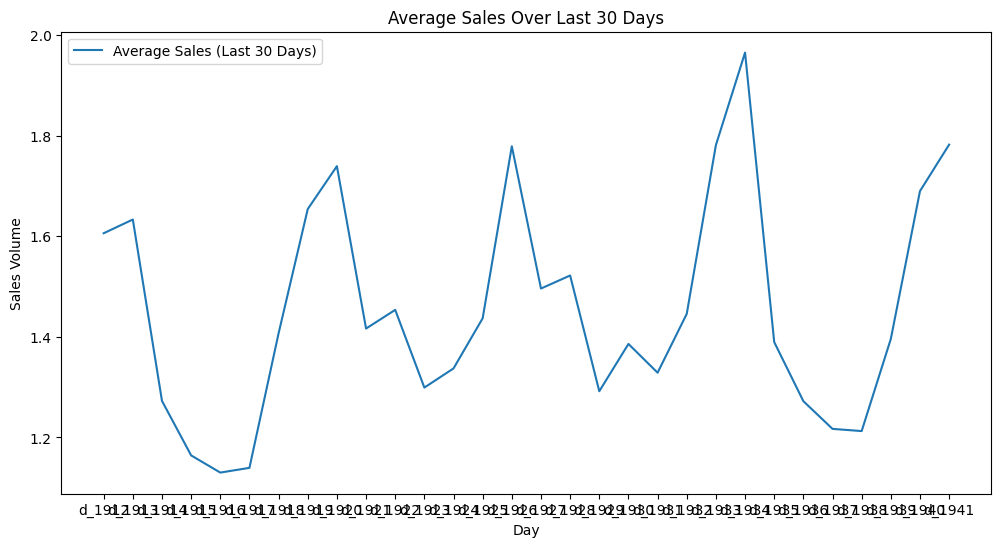

In [7]:
# Preprocessing
df_sales_train_eval.fillna(0, inplace=True)
df_sales_train_val.fillna(0, inplace=True)
df_sell_prices.fillna(method='ffill', inplace=True)

def plot_sales_data():
    plt.figure(figsize=(12,6))
    plt.plot(df_sales_train_eval.iloc[:, -30:].mean(), label='Average Sales (Last 30 Days)')
    plt.title('Average Sales Over Last 30 Days')
    plt.xlabel('Day')
    plt.ylabel('Sales Volume')
    plt.legend()
    plt.show()

plot_sales_data()

In [8]:
# GARCH Model
returns = df_sales_train_eval.iloc[:, -30:].mean().pct_change().dropna() * 100
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit()
print(garch_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 122.09909866452944
Iteration:      2,   Func. Count:     13,   Neg. LLF: 117.03764244801127
Iteration:      3,   Func. Count:     17,   Neg. LLF: 117.03764244794986
Optimization terminated successfully    (Exit mode 0)
            Current function value: 117.03764244801127
            Iterations: 3
            Function evaluations: 17
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -117.038
Distribution:                  Normal   AIC:                           242.075
Method:            Maximum Likelihood   BIC:                           247.544
                                        No. Observations:                   29
Date:               

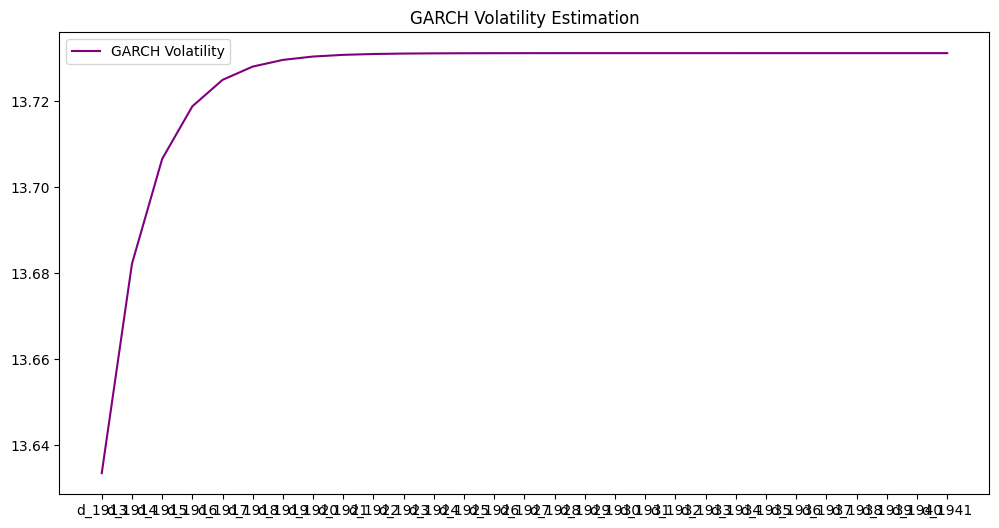

In [9]:
def plot_garch_volatility():
    plt.figure(figsize=(12,6))
    plt.plot(garch_fit.conditional_volatility, label='GARCH Volatility', color='purple')
    plt.title('GARCH Volatility Estimation')
    plt.legend()
    plt.show()

plot_garch_volatility()

C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each eleme

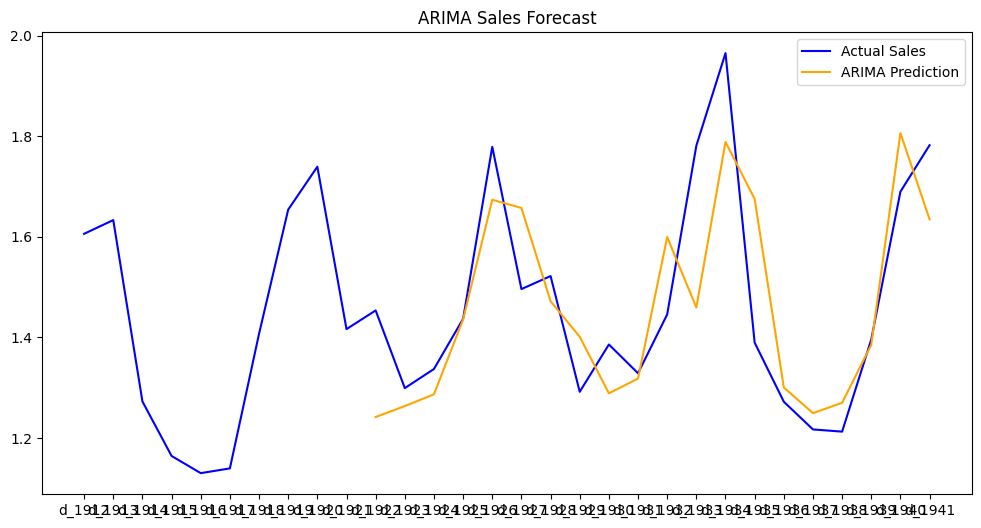

In [10]:
# ARIMA Model
arima_model = ARIMA(df_sales_train_eval.iloc[:, -30:].mean().dropna(), order=(5,1,0))
arima_fit = arima_model.fit()
forecast_arima = arima_fit.predict(start=10, dynamic=False)

def plot_arima_forecast():
    plt.figure(figsize=(12,6))
    plt.plot(df_sales_train_eval.iloc[:, -30:].mean(), label='Actual Sales', color='blue')
    plt.plot(forecast_arima, label='ARIMA Prediction', color='orange')
    plt.title('ARIMA Sales Forecast')
    plt.legend()
    plt.show()

plot_arima_forecast()

In [11]:
# LSTM Model
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_sales_train_eval.iloc[:, -30:].mean().values.reshape(-1, 1))

X, y = [], []
seq_length = 10
for i in range(len(data_scaled) - seq_length):
    X.append(data_scaled[i:i+seq_length])
    y.append(data_scaled[i+seq_length])

X, y = np.array(X), np.array(y)
X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

In [12]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))



Epoch 1/20


C:\Users\bhavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2406 - val_loss: 0.2792
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2077 - val_loss: 0.2432
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1729 - val_loss: 0.2112
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1504 - val_loss: 0.1826
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1282 - val_loss: 0.1571
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1049 - val_loss: 0.1346
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0947 - val_loss: 0.1152
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0766 - val_loss: 0.0993
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0700 - val_loss: 0.0875
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0709 - val_loss: 0.0801
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0597 - val_loss: 0.0776
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0668 - val_loss: 0.0785
Epoch 13/20
1/

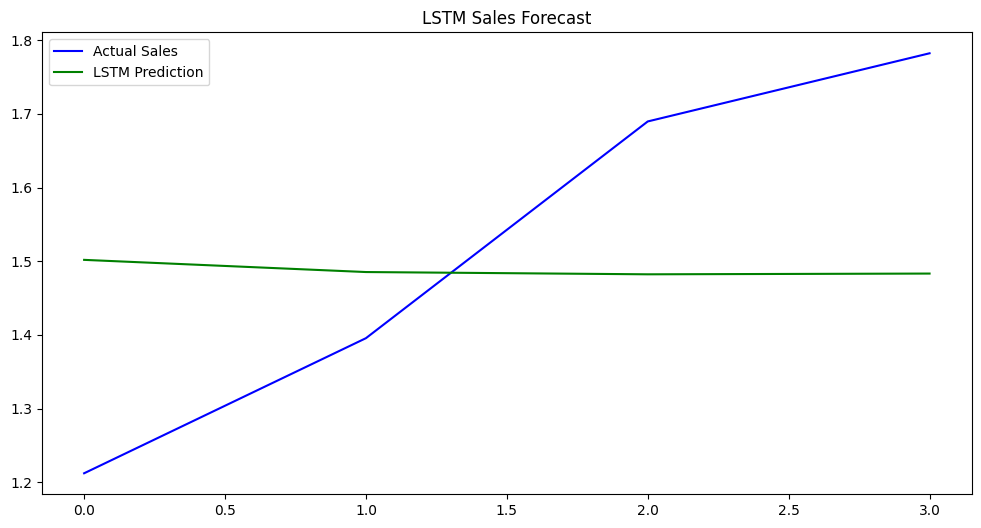

In [13]:
def plot_lstm_forecast():
    plt.figure(figsize=(12,6))
    plt.plot(y_test_inv, label='Actual Sales', color='blue')
    plt.plot(y_pred_inv, label='LSTM Prediction', color='green')
    plt.title('LSTM Sales Forecast')
    plt.legend()
    plt.show()

plot_lstm_forecast()